# Ranking
This notebook creates the XGBoost model used to rank merchants, and shows the top 100 merchants, and the top 10 merchants by our chosen segments.

In [30]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pyspark.sql.functions as F
import sklearn
import traceback
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager
from pyspark.sql.window import Window
from xgboost import plot_importance, XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [31]:
pd.set_option('display.max_columns', None)
spark = (
    SparkSession.builder.appName('Rankings')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '9g')
    .config('spark.executor.memory', '6g')
    .getOrCreate()
)

# Group transactions by merchants and date as training data

In [32]:
transactions_grouped = spark.read.parquet("../data/curated/transactions_preprocessed.parquet")
transactions_grouped = transactions_grouped.groupBy("merchant_abn", "order_datetime").agg(
    F.sum("expected_revenue").alias("expected_revenue"),
    F.mean("fraud_probability").alias("mean_fraud_probability"),
    F.mean("dollar_value").alias("mean_dollar_value"),
    F.count("merchant_abn").alias("num_sales"),
    F.first("tags").alias("tags"),
    F.first("take_rate").alias("take_rate"),
    F.mean("merchant_fraud_probability").alias("mean_merchant_fraud_probability"),
    F.mean("Median_age_persons").alias("median_age"),
    F.mean("Median_tot_fam_inc_weekly").alias("median_family_income"),
    F.mean("Median_tot_hhd_inc_weekly").alias("median_household_income"),
    F.mean("Average_household_size").alias("mean_household_size"),
    F.mean("Tot_P").alias("postcode_population"),
    F.first("day_of_week").alias("day_of_week"),
    F.first("day_of_month").alias("day_of_month"),
    F.first("day_of_year").alias("day_of_year"),
    F.first("month").alias("month"),
    F.first("year").alias("year"),
    F.mean("seasonal_sales").alias("seasonal_sales"),
    F.mean("original_sales").alias("original_sales"),
    F.first("total_seasonal_sales").alias("total_seasonal_sales"),
    F.first("total_original_sales").alias("total_original_sales"),
    F.first("is_holiday").alias("is_holiday"),
)
transactions_grouped = transactions_grouped.sort(F.col("order_datetime"), F.col("merchant_abn"))

In [33]:
# Create lagged and moving averages of a column
def create_lagged_features(df, n_lags, column):
    df[f'moving_average_{column}'] = 0
    for lag in range(1, n_lags + 1):
        df[f'lag_{column}_{lag}'] = df[column].shift(lag)
        df[f'moving_average_{column}'] += df[f'lag_{column}_{lag}']
    df[f'moving_average_{column}'] /= n_lags
    return df


def lag_feature(df, n_lags, column):
    df[column] = df[column].shift(n_lags)
    return df


def create_test_train_validate_split(X, y, train_size=0.7, val_size=0.15):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=(1 - train_size), shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(val_size / (train_size + val_size)), shuffle=False)

    return X_train, y_train, X_val, y_val, X_test, y_test


def add_date_columns(df):
    df['day_of_year'] = df['order_datetime'].dt.dayofyear
    df['day_of_month'] = df['order_datetime'].dt.day
    df['month'] = df['order_datetime'].dt.month
    df['is_holiday'] = df['order_datetime'].isin(pd.to_datetime([
        '2021-11-26',
        '2021-11-27',
        '2021-11-28',
        '2021-11-29',
        '2021-12-24',
        '2021-12-25',
        '2021-12-26',

        '2022-11-25',
        '2022-11-26',
        '2022-11-27',
        '2022-11-28',
        '2022-12-24',
        '2022-12-25',
        '2022-12-26',
    ]))
    return df


def predict_single_step(model, df, prediction_columns, imputing_columns, n_lags):
    last_row = df.tail(1)

    # Add date columns
    next_row = pd.DataFrame()
    next_row['order_datetime'] = [pd.to_datetime(last_row['order_datetime'].values[-1] + pd.Timedelta(days=1))]

    next_row = add_date_columns(next_row)

    # Add sales columns
    year = next_row['order_datetime'].dt.year.values[-1]
    month = next_row['order_datetime'].dt.month.values[-1]
    next_row['total_original_sales'], next_row['total_seasonal_sales'] = retail_sales[(year, month)]

    # Add moving average (prediction) columns
    for col in prediction_columns:
        next_row[f'moving_average_{col}'] = df.tail(n_lags)[col].mean()

    # Add columns imputed by mean
    for col in imputing_columns:
        next_row[col] = df[col].mean()

    next_row = next_row.sort_index(axis=1)
    y_pred = model.predict(next_row.drop(prediction_columns + ['order_datetime'], axis=1, errors='ignore'))

    for i, col in enumerate(prediction_columns):
        next_row[col] = y_pred[0][i]
    
    next_row = next_row.sort_index(axis=1)
    return pd.concat([df, next_row])


# Get the original and seasonal sales from a list of years and months
def get_retail_sales(years, months):
    original_sales = []
    seasonal_sales = []
    for i in range(len(years)):
        original, seasonal = retail_sales[(years[i], months[i])]
        original_sales.append(original)
        seasonal_sales.append(seasonal)
    return original_sales, seasonal_sales


def plot_predictions(actual, predicted, title='Predicted vs Actual'):
    plt.figure(figsize=(12, 6))
    
    sns.scatterplot(x=actual.index, y=actual, label='Actual', color='blue', alpha=0.6)
    sns.lineplot(x=actual.index, y=predicted, label='Predicted', color='red', linestyle='-', linewidth=2)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()


In the following graph, we can see the model's train, test and validation splits. Overall, it seems to be able to predict the trend of increasing sales up to November and December well, where expected revenue skyrockets.

Validation RMSE: 22.33888695472046


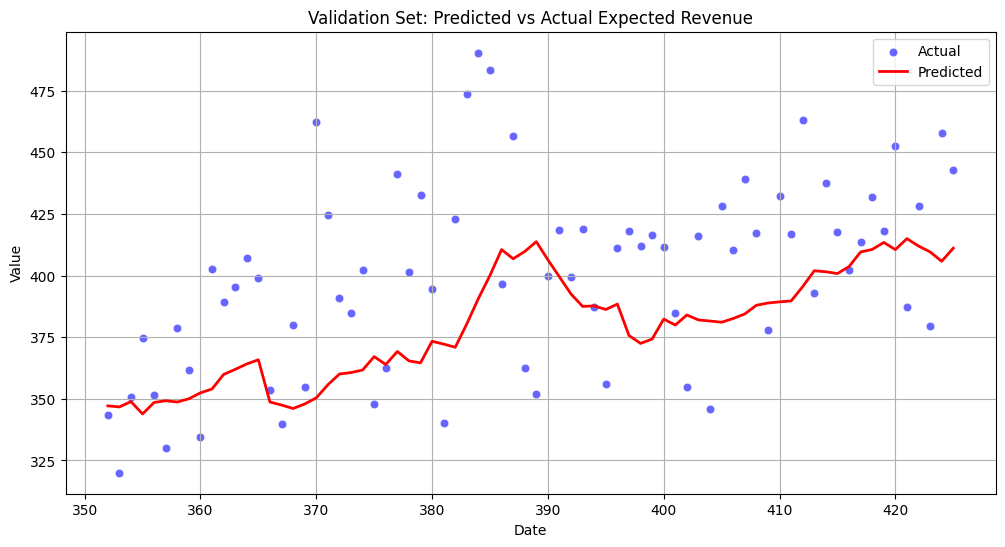

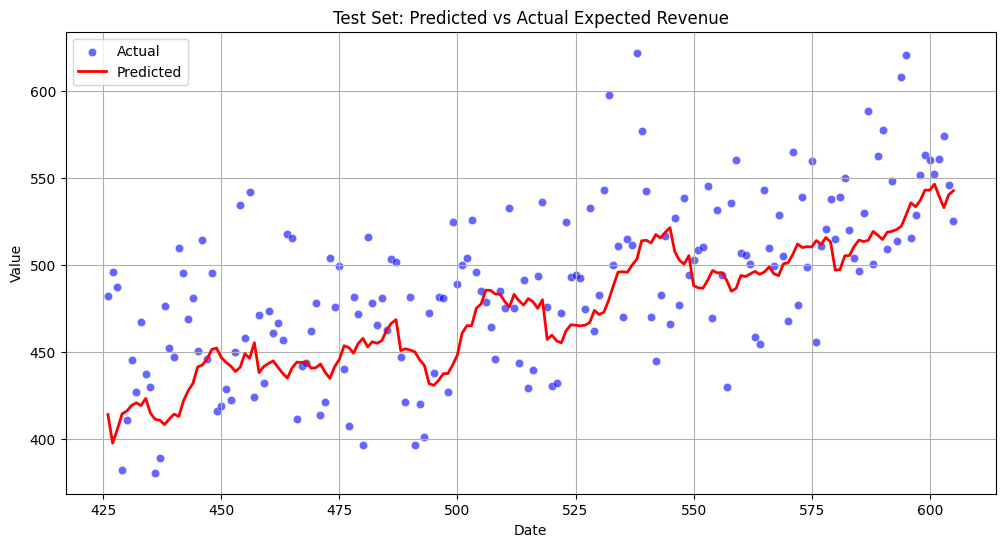

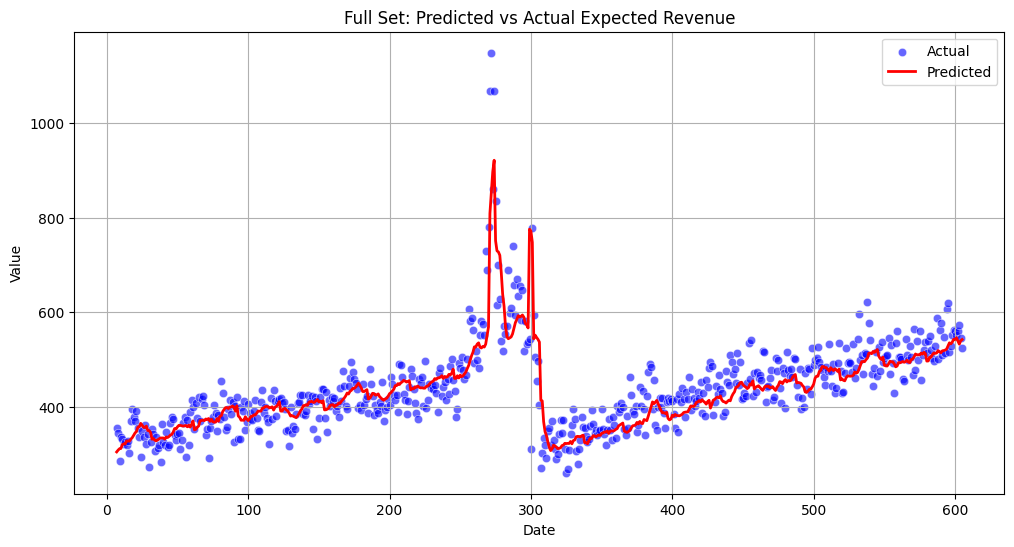

In [34]:
# Show the validation, test and training set for the XGBoost model for a single merchant
merchant_abn = '89726005175'

retail_df = spark.read.parquet("../data/raw/retail_sales.parquet")
retail_df = retail_df.withColumn("month", F.month("date"))
retail_df = retail_df.withColumn("year", F.year("date"))
retail_df = retail_df.drop('date')
retail_df = retail_df.select([col for col in retail_df.columns if not col.endswith('trend')])
result = retail_df.collect()

retail_sales = {(row['year'], row['month']): (row['Total_original'], row['Total_seasonal']) for row in result}

# Select a merchant
df = transactions_grouped.where(F.col("merchant_abn") == merchant_abn)
df = df.toPandas()


n_lags = 7
prediction_period = 90
train_size = 0.7
val_size = 0.15

# Only use moving averages of these features to avoid overfitting to the current day/day before
df = create_lagged_features(df, n_lags, 'expected_revenue')
df = create_lagged_features(df, n_lags, 'num_sales')
df = create_lagged_features(df, n_lags, 'mean_dollar_value')
df = lag_feature(df, 1, 'median_household_income')
df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
df = lag_feature(df, 1, 'mean_fraud_probability')

df = df.dropna()

DATA_COLUMNS = [
    'expected_revenue', 
    'num_sales',
    'mean_dollar_value',

    'order_datetime',
    'day_of_year', 
    'day_of_month', 
    'is_holiday', 
    'month', 

    'total_original_sales', 
    'total_seasonal_sales', 
    'postcode_population',
    'median_age',
    'median_household_income',
    'median_family_income',
    'mean_household_size',
    'mean_fraud_probability',
    'mean_merchant_fraud_probability',
    
    'moving_average_expected_revenue',
    'moving_average_num_sales',
    'moving_average_mean_dollar_value',
] 

PREDICTION_COLUMNS = [
    'expected_revenue',
    'num_sales',
    'mean_dollar_value',
]

df = df[DATA_COLUMNS]
df = df.sort_index(axis=1)

X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
y = df[PREDICTION_COLUMNS]

X_train, y_train, X_val, y_val, X_test, y_test = create_test_train_validate_split(X, y)

model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear'))
model.fit(X_train, y_train)

val_rmse = root_mean_squared_error(y_val, model.predict(X_val))
print(f'Validation RMSE: {val_rmse}')

plot_predictions(y_val['expected_revenue'], model.predict(X_val)[:,0], title='Validation Set: Predicted vs Actual Expected Revenue')
plot_predictions(y_test['expected_revenue'], model.predict(X_test)[:,0], title='Test Set: Predicted vs Actual Expected Revenue')
plot_predictions(y['expected_revenue'], model.predict(X)[:,0], title='Full Set: Predicted vs Actual Expected Revenue')

for i in range(prediction_period):
    df = predict_single_step(model, df, PREDICTION_COLUMNS, [
        'postcode_population',
        'median_age',
        'median_household_income',
        'median_family_income',
        'mean_household_size',
        'mean_fraud_probability',
        'mean_merchant_fraud_probability',
    ], 7)

# Train models

This code will run train-test-validation for the XGBoost model with time series splits for all merchants, with 5 splits for validation. This code will take several hours to run.

In [35]:
import traceback
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

merchants = [
    row.merchant_abn for row in transactions_grouped.select("merchant_abn", "expected_revenue") \
    .groupBy("merchant_abn").agg(
        F.sum("expected_revenue").alias("expected_revenue")
    ).sort(F.col("expected_revenue").desc()) \
    .collect()
]

models = []

train_size = 0.7
test_size = 0.15

end_date = '2022-10-26'
start_date = '2021-02-28'
date_range = pd.date_range(start=start_date, end=end_date)

dates_df = pd.DataFrame(date_range, columns=['order_datetime'])
dates_df['order_datetime'] = pd.to_datetime(dates_df['order_datetime'])

DATA_COLUMNS = [
    'expected_revenue', 
    'num_sales',
    'mean_dollar_value',

    'order_datetime',
    'day_of_year', 
    'day_of_month', 
    'is_holiday', 
    'month', 

    'total_original_sales', 
    'total_seasonal_sales', 

    'postcode_population',
    'median_age',
    'median_household_income',
    'median_family_income',
    'mean_household_size',
    'mean_fraud_probability',
    'mean_merchant_fraud_probability',
    
    'moving_average_expected_revenue',
    'moving_average_num_sales',
    'moving_average_mean_dollar_value',
] 

for i, merchant_abn in enumerate(merchants):
    try:
        df = transactions_grouped.where(F.col("merchant_abn") == merchant_abn).sort('order_datetime').toPandas()
        df['order_datetime'] = pd.to_datetime(df['order_datetime'])
        df = dates_df.merge(df, on='order_datetime', how='left').fillna({
            'expected_revenue': 0,
            'num_sales': 0,
            'mean_dollar_value': 0,

            'median_age': 0,
            'postcode_population': 0,
            'median_household_income': 0,
            'median_family_income': 0,
            'mean_household_size': 0,

            'mean_merchant_fraud_probability': 0,
            'mean_fraud_probability': 0,
        })

        df = add_date_columns(df)

        # Add sales columns
        years = df['order_datetime'].dt.year.values
        months = df['order_datetime'].dt.month.values
        df['total_original_sales'], df['total_seasonal_sales'] = get_retail_sales(years, months)

        # Only use moving averages of these features to avoid overfitting to the current day/day before
        df = create_lagged_features(df, n_lags, 'expected_revenue')
        df = create_lagged_features(df, n_lags, 'num_sales')
        df = create_lagged_features(df, n_lags, 'mean_dollar_value')
        df = lag_feature(df, 1, 'median_household_income')
        df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
        df = lag_feature(df, 1, 'mean_fraud_probability')

        df = df.iloc[n_lags:]

        df = df[DATA_COLUMNS]
        df = df.sort_index(axis=1)

        X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
        y = df[PREDICTION_COLUMNS]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

        # Use grid search to execute training and validation on multiple splits
        grid_search = GridSearchCV(
            MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear')),
            param_grid={
                'estimator__alpha': [0],
            },
            scoring='neg_root_mean_squared_error',
            cv=TimeSeriesSplit(n_splits=5),
            verbose=0,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        best_rank = np.argwhere(grid_search.cv_results_['rank_test_score'] == 1)[0]

        # Save model scores and metrics
        models.append({
            'merchant_abn': merchant_abn, 
            'best_alpha': grid_search.best_params_['estimator__alpha'], 
            'val_rmse': -grid_search.best_score_,
            'test_rmse': root_mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)),
            'std_val_score': grid_search.cv_results_['std_test_score'][best_rank][0],
            'fold0': -grid_search.cv_results_['split0_test_score'][best_rank][0],
            'fold1': -grid_search.cv_results_['split1_test_score'][best_rank][0],
            'fold2': -grid_search.cv_results_['split2_test_score'][best_rank][0],
            'fold3': -grid_search.cv_results_['split3_test_score'][best_rank][0],
            'fold4': -grid_search.cv_results_['split4_test_score'][best_rank][0],
        })
    except Exception as e:
        print(traceback.format_exc())

#     if i % 100 == 0:
#         results = pd.DataFrame(models)
#         results.to_csv(f"results_{i}.csv")

# Save results
results = pd.DataFrame(models)
# results.to_csv("../data/curated/results.csv")
results

,merchant_abn,best_alpha,val_rmse,test_rmse,std_val_score,fold0,fold1,fold2,fold3,fold4
0,79827781481,0,341.761275,253.652074,52.319726,359.716162,428.979573,342.788192,296.312175,281.010274
1,48534649627,0,43.891957,43.789178,14.997147,41.607487,32.112395,73.222677,34.885979,37.631247
2,86578477987,0,37.514307,26.604692,23.371538,19.018259,29.637835,83.655152,28.776978,26.483309
3,38700038932,0,168.296277,158.422819,11.604330,157.693499,173.948561,187.775297,165.720502,156.343524
4,32361057556,0,36.066237,28.647561,12.774198,27.161836,33.549092,61.258102,28.534800,29.827357
5,96680767841,0,48.469780,55.635169,12.288671,44.304195,39.176034,72.336504,46.977819,39.554348
6,21439773999,0,37.336782,27.664055,18.940027,31.410125,27.354400,74.993807,27.930938,24.994639
7,45629217853,0,37.870913,26.164370,20.560115,26.617517,31.297135,78.724375,28.551834,24.163703
8,64403598239,0,32.890933,24.940857,15.116358,27.371226,24.052335,63.028245,25.771882,24.230974
9,63123845164,0,97.728372,97.539475,10.921634,96.328798,86.153226,117.320936,89.189672,99.649227


# Predict over the next 90 days
This code will predict the daily number of sales, expected revenue, and the dollar value for all merchants, saving the results in a dataframe. This will also take several hours to run.

In [36]:
# Retrain the models on the full dataset, and make predictions 90 days later
merchants = [
    row.merchant_abn for row in transactions_grouped.select("merchant_abn", "expected_revenue") \
    .groupBy("merchant_abn").agg(
        F.sum("expected_revenue").alias("expected_revenue")
    ).sort(F.col("expected_revenue").desc()) \
    .collect()
]

models = []

# train_size = 0.7
# test_size = 0.15

# end_date = '2022-10-26'
# start_date = '2021-02-28'
# date_range = pd.date_range(start=start_date, end=end_date)

# dates_df = pd.DataFrame(date_range, columns=['order_datetime'])
# dates_df['order_datetime'] = pd.to_datetime(dates_df['order_datetime'])

DATA_COLUMNS = [
    'expected_revenue', 
    'num_sales',
    'mean_dollar_value',

    'order_datetime',
    'day_of_year', 
    'day_of_month', 
    'is_holiday', 
    'month', 

    'total_original_sales', 
    'total_seasonal_sales', 

    'postcode_population',
    'median_age',
    'median_household_income',
    'median_family_income',
    'mean_household_size',
    'mean_fraud_probability',
    'mean_merchant_fraud_probability',
    
    'moving_average_expected_revenue',
    'moving_average_num_sales',
    'moving_average_mean_dollar_value',
] 

INFO_COLUMNS = [
    'mean_dollar_value',
    'num_sales',
    'expected_revenue',

    'moving_average_mean_dollar_value',
    'moving_average_num_sales',
    'moving_average_expected_revenue',
]

for i, merchant_abn in enumerate(merchants):
    try:
        df = transactions_grouped.where(F.col("merchant_abn") == merchant_abn).sort('order_datetime').toPandas()
        df['order_datetime'] = pd.to_datetime(df['order_datetime'])
        df = dates_df.merge(df, on='order_datetime', how='left').fillna({
            'expected_revenue': 0,
            'num_sales': 0,
            'mean_dollar_value': 0,

            'median_age': 0,
            'postcode_population': 0,
            'median_household_income': 0,
            'median_family_income': 0,
            'mean_household_size': 0,

            'mean_merchant_fraud_probability': 0,
            'mean_fraud_probability': 0,
        })
        
        df = add_date_columns(df)

        # Add sales columns
        years = df['order_datetime'].dt.year.values
        months = df['order_datetime'].dt.month.values
        df['total_original_sales'], df['total_seasonal_sales'] = get_retail_sales(years, months)

        # Only use moving averages of these features to avoid overfitting to the current day/day before
        df = create_lagged_features(df, n_lags, 'expected_revenue')
        df = create_lagged_features(df, n_lags, 'num_sales')
        df = create_lagged_features(df, n_lags, 'mean_dollar_value')
        df = lag_feature(df, 1, 'median_household_income')
        df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
        df = lag_feature(df, 1, 'mean_fraud_probability')

        df = df.iloc[n_lags:]

        df = df[DATA_COLUMNS]
        df = df.sort_index(axis=1)

        X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
        y = df[PREDICTION_COLUMNS]

        model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear'))
        model.fit(X, y)

        # print(model.estimators_[0].coef_)
        # print(model.estimators_[0].feature_names_in_)

        model_data = {model.estimators_[0].feature_names_in_[i]: model.estimators_[0].coef_[i] for i in range(len(model.estimators_[0].feature_names_in_))}
        model_data['merchant_abn'] = merchant_abn

        for j in range(prediction_period):
            df = predict_single_step(model, df, PREDICTION_COLUMNS, [
                'postcode_population',
                'median_age',
                'median_household_income',
                'median_family_income',
                'mean_household_size',
                'mean_fraud_probability',
                'mean_merchant_fraud_probability',
            ], 7)

            for col in INFO_COLUMNS:
                model_data[f'{col}|{j}'] = df.iloc[-1][col]
        
        for col in INFO_COLUMNS:
            model_data[f'{col}_predicted_sum'] = df.iloc[-90:][col].sum()

        models.append(model_data)

    except Exception as e:
        print(traceback.format_exc())

    # if i % 100 == 0:
    #     print(i, end=' ')
    #     results = pd.DataFrame(models)
    #     results.to_csv(f"predictions_{i}.csv")

results = pd.DataFrame(models)
# results.to_csv("../data/curated/predictions.csv")
results

,day_of_month,day_of_year,is_holiday,mean_fraud_probability,mean_household_size,mean_merchant_fraud_probability,median_age,median_family_income,median_household_income,month,moving_average_expected_revenue,moving_average_mean_dollar_value,moving_average_num_sales,postcode_population,total_original_sales,total_seasonal_sales,merchant_abn,mean_dollar_value|0,num_sales|0,expected_revenue|0,moving_average_mean_dollar_value|0,moving_average_num_sales|0,moving_average_expected_revenue|0,mean_dollar_value|1,num_sales|1,expected_revenue|1,moving_average_mean_dollar_value|1,moving_average_num_sales|1,moving_average_expected_revenue|1,mean_dollar_value|2,num_sales|2,expected_revenue|2,moving_average_mean_dollar_value|2,moving_average_num_sales|2,moving_average_expected_revenue|2,mean_dollar_value|3,num_sales|3,expected_revenue|3,moving_average_mean_dollar_value|3,moving_average_num_sales|3,moving_average_expected_revenue|3,mean_dollar_value|4,num_sales|4,expected_revenue|4,moving_average_mean_dollar_value|4,moving_average_num_sales|4,moving_average_expected_revenue|4,mean_dollar_value|5,num_sales|5,expected_revenue|5,moving_average_mean_dollar_value|5,moving_average_num_sales|5,moving_average_expected_revenue|5,mean_dollar_value|6,num_sales|6,expected_revenue|6,moving_average_mean_dollar_value|6,moving_average_num_sales|6,moving_average_expected_revenue|6,mean_dollar_value|7,num_sales|7,expected_revenue|7,moving_average_mean_dollar_value|7,moving_average_num_sales|7,moving_average_expected_revenue|7,mean_dollar_value|8,num_sales|8,expected_revenue|8,moving_average_mean_dollar_value|8,moving_average_num_sales|8,moving_average_expected_revenue|8,mean_dollar_value|9,num_sales|9,expected_revenue|9,moving_average_mean_dollar_value|9,moving_average_num_sales|9,moving_average_expected_revenue|9,mean_dollar_value|10,num_sales|10,expected_revenue|10,moving_average_mean_dollar_value|10,moving_average_num_sales|10,moving_average_expected_revenue|10,mean_dollar_value|11,num_sales|11,expected_revenue|11,moving_average_mean_dollar_value|11,moving_average_num_sales|11,moving_average_expected_revenue|11,mean_dollar_value|12,num_sales|12,expected_revenue|12,moving_average_mean_dollar_value|12,moving_average_num_sales|12,moving_average_expected_revenue|12,mean_dollar_value|13,num_sales|13,expected_revenue|13,moving_average_mean_dollar_value|13,moving_average_num_sales|13,moving_average_expected_revenue|13,mean_dollar_value|14,num_sales|14,expected_revenue|14,moving_average_mean_dollar_value|14,moving_average_num_sales|14,moving_average_expected_revenue|14,mean_dollar_value|15,num_sales|15,expected_revenue|15,moving_average_mean_dollar_value|15,moving_average_num_sales|15,moving_average_expected_revenue|15,mean_dollar_value|16,num_sales|16,expected_revenue|16,moving_average_mean_dollar_value|16,moving_average_num_sales|16,moving_average_expected_revenue|16,mean_dollar_value|17,num_sales|17,expected_revenue|17,moving_average_mean_dollar_value|17,moving_average_num_sales|17,moving_average_expected_revenue|17,mean_dollar_value|18,num_sales|18,expected_revenue|18,moving_average_mean_dollar_value|18,moving_average_num_sales|18,moving_average_expected_revenue|18,mean_dollar_value|19,num_sales|19,expected_revenue|19,moving_average_mean_dollar_value|19,moving_average_num_sales|19,moving_average_expected_revenue|19,mean_dollar_value|20,num_sales|20,expected_revenue|20,moving_average_mean_dollar_value|20,moving_average_num_sales|20,moving_average_expected_revenue|20,mean_dollar_value|21,num_sales|21,expected_revenue|21,moving_average_mean_dollar_value|21,moving_average_num_sales|21,moving_average_expected_revenue|21,mean_dollar_value|22,num_sales|22,expected_revenue|22,moving_average_mean_dollar_value|22,moving_average_num_sales|22,moving_average_expected_revenue|22,mean_dollar_value|23,num_sales|23,expected_revenue|23,moving_average_mean_dollar_value|23,moving_average_num_sales|23,moving_average_expected_revenue|23,mean_dollar_value|24,num_sales|24,expected_revenu

# View predictions for a single merchant

In [37]:
# Get the results and create a dataframe to fill with predictions for a single merchant
merchant_abn = '89726005175'
graph_column = 'expected_revenue'

transactions = transactions_grouped.where(F.col("merchant_abn") == merchant_abn).toPandas()
tbl_merchants = spark.read.parquet("../data/curated/tbl_merchants")

training_results = spark.read.option("header", "true").csv("../data/curated/results.csv")
training_results = training_results.drop(training_results.columns[0])

predictions = spark.read.option("header", "true").csv("../data/curated/predictions.csv")
predictions = predictions.drop(predictions.columns[0])

results = predictions.join(training_results, on='merchant_abn', how='inner')
results = results.select(*[F.col(column).cast(DoubleType()).alias(column) if column not in ['order_datetime', 'merchant_abn'] else F.col(column) for column in results.columns])
results = results.join(tbl_merchants, on='merchant_abn', how='left')

merchant_stats = spark.read.parquet("../data/curated/transactions_preprocessed.parquet").groupBy('merchant_abn').agg(
    F.mean("merchant_fraud_probability").alias("merchant_mean_merchant_fraud_probability"),
    F.mean("fraud_probability").alias("merchant_mean_consumer_fraud_probability"),
    F.mean("dollar_value").alias("merchant_mean_dollar_value"),
    F.mean("expected_revenue").alias("merchant_mean_expected_revenue"),
)
results = results.join(merchant_stats, on='merchant_abn', how='left')

expected_revenue_columns = ','.join([f"`{graph_column}|{i}`" for i in range(prediction_period)])

merchant_results = results.where(F.col("merchant_abn") == merchant_abn).selectExpr(
    f"stack(90, {expected_revenue_columns}) as (predicted)"
).toPandas()

merchant_results['order_datetime'] = pd.date_range(
    transactions['order_datetime'].values[-1] + pd.Timedelta(days=1), 
    transactions['order_datetime'].values[-1] + pd.Timedelta(days=90), 
)

We can see from the following graph, that the model is able to predict the holiday period relatively well, with spikes in revenue on holidays like Black Friday and Boxing day.

Additionally, we can see that the model predicts the overall trend well, not overfitting on the noise in the training set.

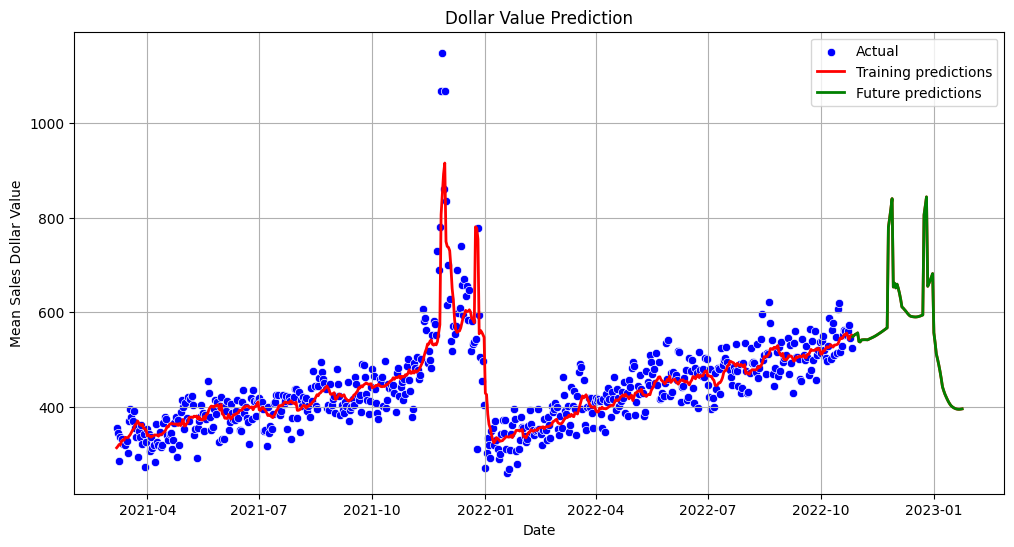

In [38]:
# Combine results and predictions dataframes to get merchant data, then plot the predictions for a merchant
df = transactions
df = create_lagged_features(df, n_lags, 'expected_revenue')
df = create_lagged_features(df, n_lags, 'num_sales')
df = create_lagged_features(df, n_lags, 'mean_dollar_value')
df = lag_feature(df, 1, 'median_household_income')
df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
df = lag_feature(df, 1, 'mean_fraud_probability')

df = df.iloc[n_lags:]
df = df[DATA_COLUMNS]
df = df.sort_index(axis=1)

X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
y = df[PREDICTION_COLUMNS]

model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear'))
model.fit(X, y)

df['predicted'] = model.predict(X)[:, PREDICTION_COLUMNS.index(graph_column)].astype(np.float64)
df = pd.concat([df, merchant_results])
df['order_datetime'] = pd.to_datetime(df['order_datetime'])
df = df.sort_values(by='order_datetime')

def plot_predictions(data, title='Revenue Prediction', y_label='Expected Revenue'):
    plt.figure(figsize=(12, 6))

    sns.scatterplot(data.iloc[:-prediction_period], x='order_datetime', y=graph_column, label='Actual', color='blue')
    ax = sns.lineplot(data, x='order_datetime', y='predicted', label='Training predictions', color='red', linewidth=2)
    ax = sns.lineplot(data.tail(prediction_period), x='order_datetime', y='predicted', label='Future predictions', color='green', linewidth=2)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()

plot_predictions(df, "Dollar Value Prediction", "Mean Sales Dollar Value")

We can see in the feature weights, that the `is_holiday` factor is the largest, indicating on a holiday like Black Friday, we expect the merchant's revenue to be on average `$211` greater.

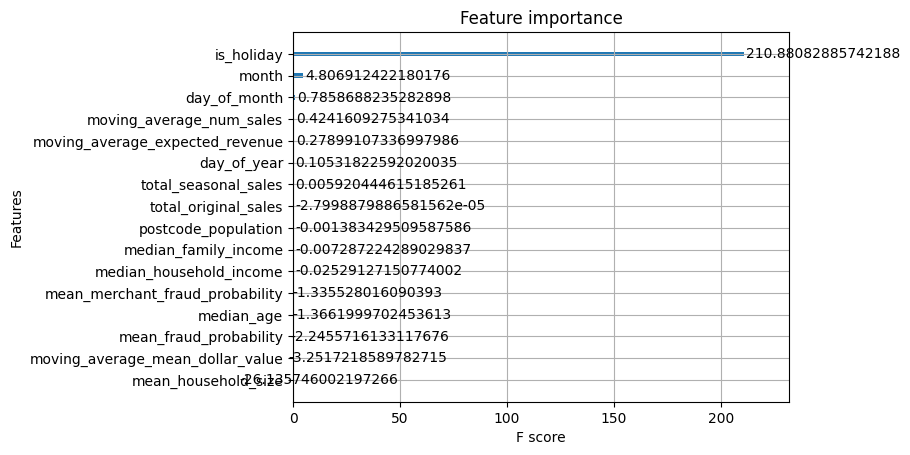

[ 7.85869e-01  1.05318e-01  2.10881e+02 -2.24557e+00 -2.61357e+01
 -1.33553e+00 -1.36620e+00 -7.28722e-03 -2.52913e-02  4.80691e+00
  2.78991e-01 -3.25172e+00  4.24161e-01 -1.38343e-03 -2.79989e-05
  5.92044e-03]
['day_of_month' 'day_of_year' 'is_holiday' 'mean_fraud_probability'
 'mean_household_size' 'mean_merchant_fraud_probability' 'median_age'
 'median_family_income' 'median_household_income' 'month'
 'moving_average_expected_revenue' 'moving_average_mean_dollar_value'
 'moving_average_num_sales' 'postcode_population' 'total_original_sales'
 'total_seasonal_sales']


In [39]:
# Plot weight of each feature in the model
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model.estimators_[0], importance_type='weight')
plt.show()

print(model.estimators_[0].coef_)
print(model.estimators_[0].feature_names_in_)

## Demand curve
We can view the demand curve for this merchant across the last 90 days, which allows us to make predictions on how much revenue we will receive by changing the take rate for this merchant (and subsequently how much revenue we receive from them).

If the demand is inelastic, by increasing the take rate (and our expected revenue), the number of sales will decrease by a smaller proportion, resulting in a higher total revenue (our expected revenue * number of sales)

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_12952/1841884499.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


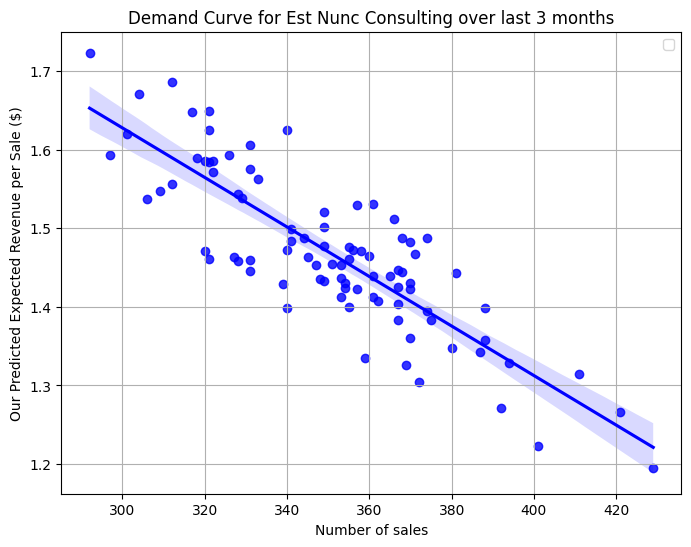

                            OLS Regression Results                            
Dep. Variable:              num_sales   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     222.8
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           7.73e-26
Time:                        19:26:50   Log-Likelihood:                -368.03
No. Observations:                  90   AIC:                             740.1
Df Residuals:                      88   BIC:                             745.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.figure(figsize=(8, 6))
df['expected_revenue_per_sale'] = df['predicted'] / df['num_sales']
sns.regplot(df[-prediction_period * 2:-prediction_period], x='num_sales', y='expected_revenue_per_sale', color='blue', fit_reg=True)

plt.title("Demand Curve for Est Nunc Consulting over last 3 months")
plt.xlabel('Number of sales')
plt.ylabel('Our Predicted Expected Revenue per Sale ($)')
plt.legend()
plt.grid()
plt.show()

model = smf.ols('num_sales ~ expected_revenue_per_sale', data=df[-prediction_period * 2:-prediction_period]).fit()
print(model.summary())

In [41]:
clusters = spark.read.parquet('../data/curated/clusters.parquet')

# Select key columns to include in ranked merchant results
ranked_merchants = results.join(clusters, on='merchant_abn', how='left').select(
    # Merchant details
    "merchant_abn",
    "merchant_name",
    "merchant_mean_merchant_fraud_probability",
    "merchant_mean_consumer_fraud_probability",
    "tags",
    "type",
    "cluster",

    # The following are the coefficients learned by the model
    "merchant_mean_dollar_value",
    "merchant_mean_expected_revenue",
    "take_rate",
    "day_of_month",
    "day_of_year",
    "is_holiday",
    "mean_fraud_probability",
    "mean_household_size",
    "mean_merchant_fraud_probability",
    "median_age",
    "median_family_income",
    "median_household_income",
    "month",
    "moving_average_expected_revenue",
    "moving_average_mean_dollar_value",
    "moving_average_num_sales",
    "postcode_population",
    "total_original_sales",
    "total_seasonal_sales",

    # Testing and validation scores
    "std_val_score",
    "test_rmse",
    "val_rmse",

    # Future predictions summed
    "num_sales_predicted_sum",
    "mean_dollar_value_predicted_sum",
    "expected_revenue_predicted_sum",
).sort(F.col("expected_revenue_predicted_sum").desc())

window_spec = Window.orderBy(F.desc("expected_revenue_predicted_sum"))
ranked_merchants = ranked_merchants.withColumn("row_num", F.row_number().over(window_spec))
ranked_merchants.select('row_num', 'merchant_abn', 'expected_revenue_predicted_sum')

ranked_merchants.show(100, truncate=False)
# ranked_merchants.write.mode("overwrite").csv("../data/curated/ranking.csv")

24/10/16 19:26:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 19:26:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 19:26:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 19:26:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 19:26:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 19:26:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 1

+------------+---------------------------------+----------------------------------------+----------------------------------------+----------------------------------------------------------------+----+---------------------+--------------------------+------------------------------+---------+------------+-----------+----------+----------------------+-------------------+-------------------------------+-----------+--------------------+-----------------------+---------+-------------------------------+--------------------------------+------------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------------+-------------------------------+------------------------------+-------+
|merchant_abn|merchant_name                    |merchant_mean_merchant_fraud_probability|merchant_mean_consumer_fraud_probability|tags                                                            |type|cluster              |merch

In the following graph, we can see the take rates are greater for the top 100 merchants. In fact, 9 out of 10 merchants in the top 10 have take rates greater than 6%.

24/10/16 19:27:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 19:27:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 19:27:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 19:27:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 19:27:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 19:27:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/16 1

<Figure size 800x600 with 0 Axes>

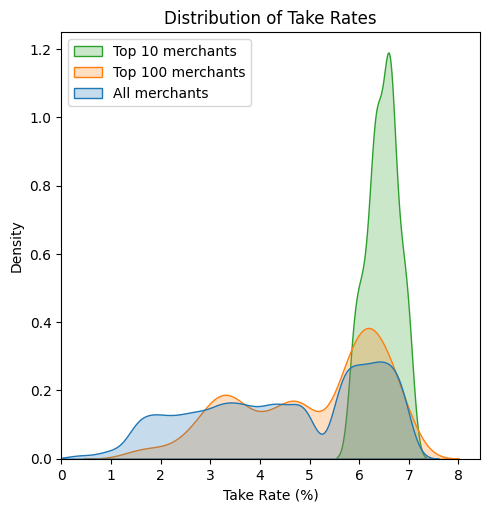

In [42]:
# Show distribution of take rates for the top 100 merchants
removed_fraud = ranked_merchants.where(F.col("merchant_mean_merchant_fraud_probability") < 50.0)

removed_fraud = removed_fraud.withColumn("row_num", F.row_number().over(window_spec)) \
    .withColumn("is_first_100", F.when(F.col("row_num") <= 100, 1).otherwise(0)) \
    .drop("row_num")

removed_fraud = removed_fraud.withColumn("row_num", F.row_number().over(window_spec)) \
    .withColumn("is_first_10", F.when(F.col("row_num") <= 10, 1).otherwise(0)) \
    .drop("row_num")

removed_fraud = removed_fraud.sort(F.col("expected_revenue_predicted_sum").desc()).toPandas()

all_merchants = removed_fraud.copy()
all_merchants['subset'] = 'All merchants'

top_100_merchants = removed_fraud.iloc[:100].copy()
top_100_merchants['subset'] = 'Top 100 merchants'

top_10_merchants = removed_fraud.iloc[:10].copy()
top_10_merchants['subset'] = 'Top 10 merchants'

merged_data = pd.concat([all_merchants, top_100_merchants, top_10_merchants])

plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='take_rate', hue="subset", bw_adjust=0.6, kind="kde", common_norm=False, legend=False, fill=True)

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Take Rates")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper left")
plt.xlabel("Take Rate (%)")
plt.ylabel("Density")
plt.xlim(0)

plt.show()

In the following fraud graphs, we can see the distribution of fraud rates are generally similar to the general merchant and consumer population. Still, we can see the fraud rates for merchants in the top 10 are lower on average.

<Figure size 800x600 with 0 Axes>

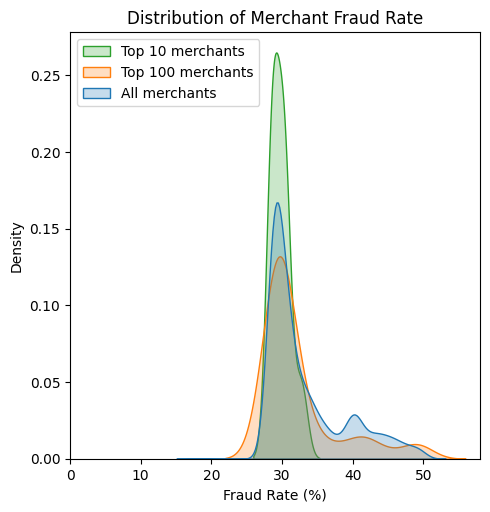

In [43]:
# Show distribution of merchant fraud rate for the top 100 merchants
plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='merchant_mean_merchant_fraud_probability', hue="subset", bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Merchant Fraud Rate")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper left")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Density")
plt.xlim(0)

plt.show()


<Figure size 800x600 with 0 Axes>

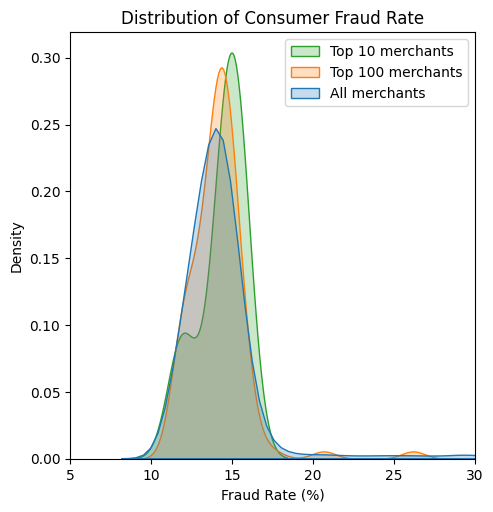

In [44]:
# Show distribution of consumer fraud rate for the top 100 merchants
plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='merchant_mean_consumer_fraud_probability', hue="subset", bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Consumer Fraud Rate")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper right")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Density")
plt.xlim((5, 30))

plt.show()

Additionally, we can see that the top 100 merchants receive more expected revenue on holidays.

<Figure size 800x600 with 0 Axes>

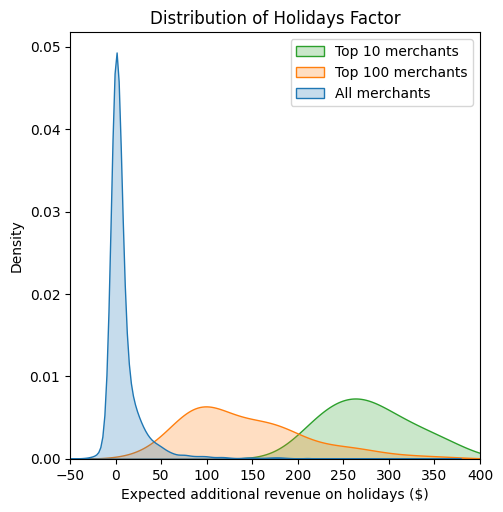

In [45]:
# Show distribution of holidays factor for the top 100 merchants
plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='is_holiday', hue="subset", bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Holidays Factor")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper right")
plt.xlabel("Expected additional revenue on holidays ($)")
plt.ylabel("Density")
plt.xlim((-50, 400))

plt.show()

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_12952/3481060926.py:8: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(best_clustered, x='expected_revenue_predicted_sum', hue='cluster', palette=sns.color_palette(), fill=True, bw_adjust=0.5)


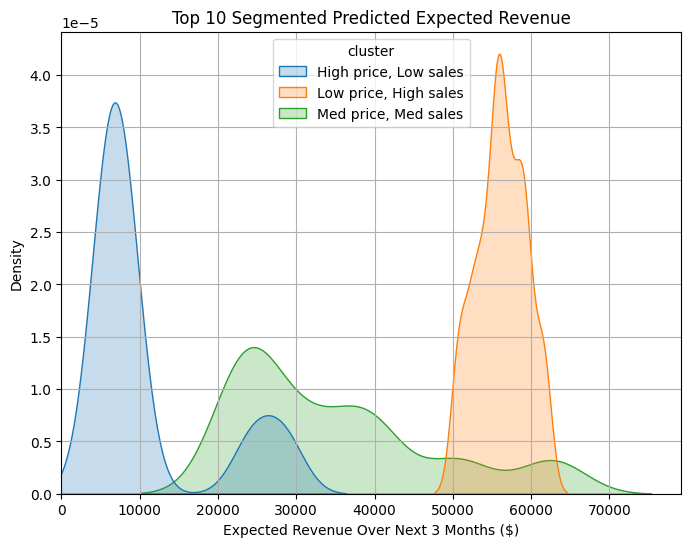

In [46]:
window_spec = Window.partitionBy("cluster").orderBy(F.desc("expected_revenue_predicted_sum"))
row_df = ranked_merchants.withColumn("row_num", F.row_number().over(window_spec))

best_clustered = row_df.filter(row_df.row_num <= 10).drop("row_num")
best_clustered = best_clustered.toPandas()

plt.figure(figsize=(8, 6))
sns.kdeplot(best_clustered, x='expected_revenue_predicted_sum', hue='cluster', palette=sns.color_palette(), fill=True, bw_adjust=0.5)
plt.title("Top 10 Segmented Predicted Expected Revenue")
plt.xlabel("Expected Revenue Over Next 3 Months ($)")
plt.ylabel("Density")
plt.xlim(0)
plt.grid()


/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_12952/1935323989.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(best_clustered, x='test_rmse', hue='cluster', palette=sns.color_palette(), fill=True, bw_adjust=0.5)


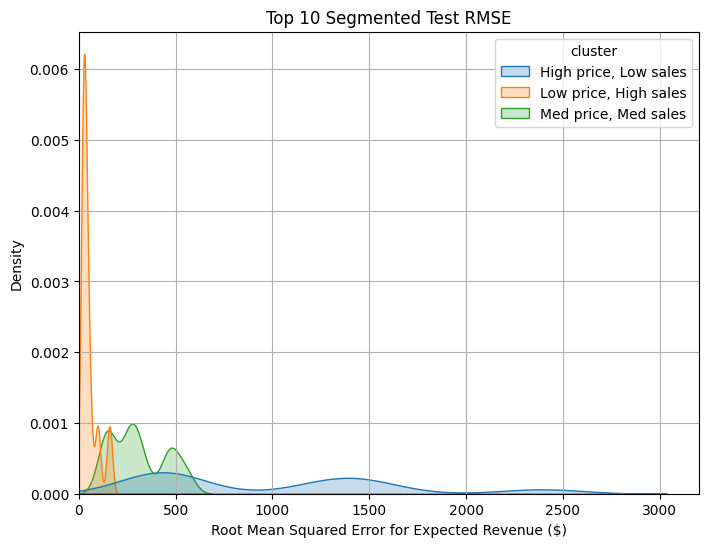

In [47]:
plt.figure(figsize=(8, 6))
sns.kdeplot(best_clustered, x='test_rmse', hue='cluster', palette=sns.color_palette(), fill=True, bw_adjust=0.5)
plt.title("Top 10 Segmented Test RMSE")
plt.xlabel("Root Mean Squared Error for Expected Revenue ($)")
plt.ylabel("Density")
plt.xlim(0)
plt.grid()